In [1]:
import copy
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import inspect
import pandas as pd

from notebook_utils import *

sys.path.insert(0, "..")
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
ls = [
    "solid", # Solid      # Same as (0, ()) or '-'
    "dashed",
    "dotted", # Dotted,    # Same as (0, (1, 1)) or ':'
    "dashdot",
    (0, (3, 5, 1, 5)), # dashdotted
    (3, (10, 3)),
    (0, (3, 5, 1, 5, 1, 5)),
    (0, (3, 10, 1, 10)),
]

def lambd_str(lam):
    return "1/16" if abs(16 * lam - 1) < 1e-4 else f"{str(int(lam*8))}/8"

In [3]:
#######################################################
# Q1: theoretical stability
#######################################################

In [4]:
def q1_plot_method(model_type, method_type, rs, plot_rs,
                   title = None, lfs = 10, afs = 14, tfs = 16):
    
    plt.clf()
    div_by_p = model_type.lower() == "roberta"
    
    # q1t_lambds = [8/8, 4/8, 3/8, 2/8, 1/8]
    q1t_lambds = [8/8, 4/8, 2/8, 1/8, 1/16]
    
    top_fracs = [1/8, 2/8, 3/8, 4/8]
    top1_dfs = [(l,load_q1_theory(model_type, method_type, 1/8, l)) for l in q1t_lambds]
    top2_dfs = [(l,load_q1_theory(model_type, method_type, 2/8, l)) for l in q1t_lambds]
    top3_dfs = [(l,load_q1_theory(model_type, method_type, 3/8, l)) for l in q1t_lambds]
    top4_dfs = [(l,load_q1_theory(model_type, method_type, 4/8, l)) for l in q1t_lambds]
    
    fig, ax = plt.subplots(3,2, figsize=(6.4*2, 4.8*2))
    
    for i, (lambd, df) in enumerate(top1_dfs):
        inc_drops = q1t_drops(df, rs, prop="inc", div_by_p=div_by_p)
        dec_drops = q1t_drops(df, rs, prop="dec", div_by_p=div_by_p)
        ax[0,0].plot(plot_rs, inc_drops, label=f"λ={lambd_str(lambd)} ({inc_drops[0]:.3f})", linestyle=ls[i])
        ax[0,1].plot(plot_rs, dec_drops, label=f"λ={lambd_str(lambd)} ({dec_drops[0]:.3f})", linestyle=ls[i])
        
        
    for i, (lambd, df) in enumerate(top2_dfs):
        inc_drops = q1t_drops(df, rs, prop="inc", div_by_p=div_by_p)
        dec_drops = q1t_drops(df, rs, prop="dec", div_by_p=div_by_p)
        ax[1,0].plot(plot_rs, inc_drops, label=f"λ={lambd_str(lambd)} ({inc_drops[0]:.3f})", linestyle=ls[i])
        ax[1,1].plot(plot_rs, dec_drops, label=f"λ={lambd_str(lambd)} ({dec_drops[0]:.3f})", linestyle=ls[i])
        
    for i, (lambd, df) in enumerate(top3_dfs):
        inc_drops = q1t_drops(df, rs, prop="inc", div_by_p=div_by_p)
        dec_drops = q1t_drops(df, rs, prop="dec", div_by_p=div_by_p)
        ax[2,0].plot(plot_rs, inc_drops, label=f"λ={lambd_str(lambd)} ({inc_drops[0]:.3f})", linestyle=ls[i])
        ax[2,1].plot(plot_rs, dec_drops, label=f"λ={lambd_str(lambd)} ({dec_drops[0]:.3f})", linestyle=ls[i])

    for i in range(3):
        tf_str = f"{int(top_fracs[i]*8)}/8"
        ax[i,0].legend(loc="upper right", title=f"Cons+IncStab ({method_type}-{tf_str})", fontsize=lfs, title_fontsize=lfs)
        ax[i,1].legend(loc="upper right", title=f"Cons+DecStab ({method_type}-{tf_str})", fontsize=lfs, title_fontsize=lfs)
        ax[i,0].set_ylabel("Prop Hold Rate", fontsize=afs)
        
    for i in range(3):
        for j in [0,1]:
            ax[i,j].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])
            ax[i,j].tick_params(axis="x", labelsize=lfs)
            ax[i,j].tick_params(axis="y", labelsize=lfs)
    
    if title is not None:
        fig.suptitle(title, fontsize=tfs, y=0.91)
    
    ax[-1,0].set_xlabel("Fraction of Features", fontsize=afs)
    ax[-1,1].set_xlabel("Fraction of Features", fontsize=afs)
    return fig

<Figure size 640x480 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

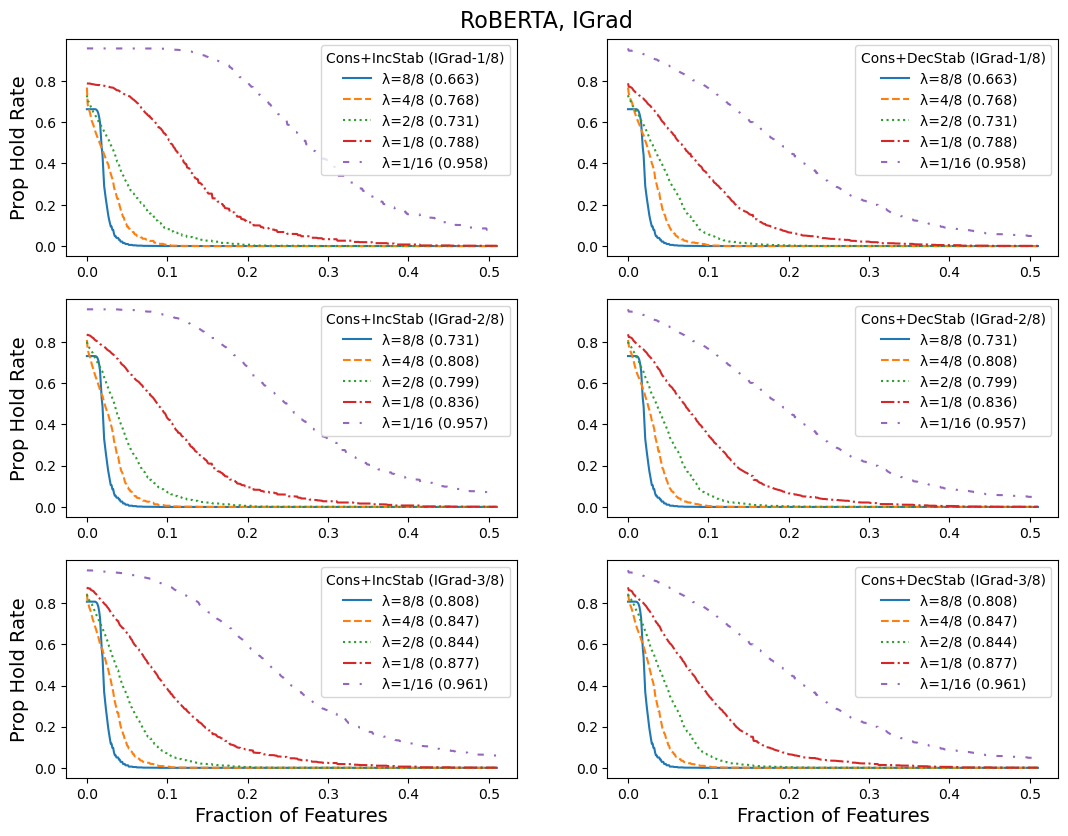

In [5]:
q1t_methods = ["SHAP", "LIME", "VGrad", "IGrad"]

q1t_vit16_rs = np.linspace(0.0, 4.1, 500)
q1t_vit16_plot_rs = q1t_vit16_rs / 64
for method in q1t_methods:
    title = f"Vision Transformer, {method}"
    _ = q1_plot_method("ViT16", method, q1t_vit16_rs, q1t_vit16_plot_rs, title=title)
    plt.savefig(f"images/q1t_vit16_{method.lower()}.png", bbox_inches="tight", transparent=True)

q1t_resnet50_rs = q1t_vit16_rs
q1t_resnet50_plot_rs = q1t_vit16_plot_rs
for method in q1t_methods:
    title = f"ResNet50, {method}"
    _ = q1_plot_method("ResNet50", method, q1t_resnet50_rs, q1t_resnet50_plot_rs, title=title)
    plt.savefig(f"images/q1t_resnet50_{method.lower()}.png", bbox_inches="tight", transparent=True)

q1t_roberta_rs = np.linspace(0.0, 0.41, 500)
q1t_roberta_plot_rs = np.linspace(0.0, 0.51, 500)
for method in q1t_methods:
    title = f"RoBERTA, {method}"
    _ = q1_plot_method("RoBERTa", method, q1t_roberta_rs, q1t_roberta_plot_rs, title=title)
    plt.savefig(f"images/q1t_roberta_{method.lower()}.png", bbox_inches="tight", transparent=True)
    

In [6]:
##################################################################
### Q1 empirical stability: only for SHAP top-25%
##################################################################

In [7]:
def q1_plot_cert_vs_emp(model_type, trs, plot_trs, ers, plot_ers,
                        title = None,
                        lfs = 10,
                        afs = 12,
                        tfs = 14,
                        show_lhs = True,
                        subplot_titles = False):
    plt.clf()
    fig, ax = plt.subplots(2,2, figsize=(6.4 * 2, 4.8*1.2))

    q1t_lambds = [8/8, 4/8, 2/8, 1/8]
    q1e_lambds = [8/8, 4/8, 2/8, 1/8]
    q1t_dfs = [(l, load_q1_theory(model_type, "shap", 0.25, l)) for l in q1t_lambds]
    q1e_dfs = [(l, load_q1_boxatk(model_type, "shap", 0.25, l)) for l in q1e_lambds]
    div_by_p = model_type.lower() == "roberta"
    
    for i, (lambd, df) in enumerate(q1t_dfs):
        inc_drops = q1t_drops(df, trs, prop="inc", div_by_p=div_by_p)
        dec_drops = q1t_drops(df, trs, prop="dec", div_by_p=div_by_p)
        if show_lhs:
            ax[0,0].plot(plot_trs, inc_drops, label=f"λ={int(lambd*8)}/8 ({inc_drops[0]:.3f})", linestyle=ls[i])
            ax[0,1].plot(plot_trs, dec_drops, label=f"λ={int(lambd*8)}/8 ({dec_drops[0]:.3f})", linestyle=ls[i])
        else:
            ax[0,0].plot(plot_trs, inc_drops, label=f"λ={int(lambd*8)}/8")
            ax[0,1].plot(plot_trs, dec_drops, label=f"λ={int(lambd*8)}/8")
            

    for i, (lambd, df) in enumerate(q1e_dfs):
        inc_drops = q1e_drops(df, ers, prop="inc", div_by_p=div_by_p)
        dec_drops = q1e_drops(df, ers, prop="dec", div_by_p=div_by_p)
        if show_lhs:
            ax[1,0].plot(plot_ers, inc_drops, label=f"λ={int(lambd*8)}/8 ({inc_drops[0]:.3f})", linestyle=ls[i])
            ax[1,1].plot(plot_ers, dec_drops, label=f"λ={int(lambd*8)}/8 ({dec_drops[0]:.3f})", linestyle=ls[i])
        else:
            ax[1,0].plot(plot_ers, inc_drops, label=f"λ={int(lambd*8)}/8")
            ax[1,1].plot(plot_ers, dec_drops, label=f"λ={int(lambd*8)}/8")
        
    if subplot_titles:
        emp_legend_loc = "lower left" if model_type == "roberta" else "upper right"
        ax[0,0].legend(loc="upper right", fontsize=lfs, title_fontsize=lfs)
        ax[0,1].legend(loc="upper right", title_fontsize=lfs)
        ax[1,0].legend(loc=emp_legend_loc, fontsize=lfs, title_fontsize=lfs)
        ax[1,1].legend(loc=emp_legend_loc, fontsize=lfs, title_fontsize=lfs)
        
        ax[0,0].set_title("Certified Consistent and Inc Stable", fontsize=tfs)
        ax[0,1].set_title("Certified Consistent and Dec Stable", fontsize=tfs)
        ax[1,0].set_title("Empirical Consistent and Inc Stable", fontsize=tfs)
        ax[1,1].set_title("Empirical Consistent and Dec Stable", fontsize=tfs)
        fig.subplots_adjust(hspace=0.35)
        
    else:
        emp_legend_loc = "lower left" if model_type == "roberta" else "upper right"
        ax[0,0].legend(loc="upper right", title="Cert Cons+IncStab", fontsize=lfs, title_fontsize=lfs)
        ax[0,1].legend(loc="upper right", title="Cert Cons+DecStab", fontsize=lfs, title_fontsize=lfs)
        ax[1,0].legend(loc=emp_legend_loc, title="Emp Cons+IncStab", fontsize=lfs, title_fontsize=lfs)
        ax[1,1].legend(loc=emp_legend_loc, title="Emp Cons+DecStab", fontsize=lfs, title_fontsize=lfs)
        
    for i in [0,1]:
        for j in [0,1]:
            ax[i,j].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])
            ax[i,j].tick_params(axis="x", labelsize=lfs)
            ax[i,j].tick_params(axis="y", labelsize=lfs)

    ax[1,0].set_xlabel("Fraction of Features", fontsize=afs)
    ax[1,1].set_xlabel("Fraction of Features", fontsize=afs)
    ax[0,0].set_ylabel("Prop Hold Rate", fontsize=afs)
    ax[1,0].set_ylabel("Prop Hold Rate", fontsize=afs)
    
    if title is not None:
        fig.suptitle(title, fontsize=tfs, y=0.93)
    
    return fig

<Figure size 640x480 with 0 Axes>

<Figure size 1280x576 with 0 Axes>

<Figure size 1280x576 with 0 Axes>

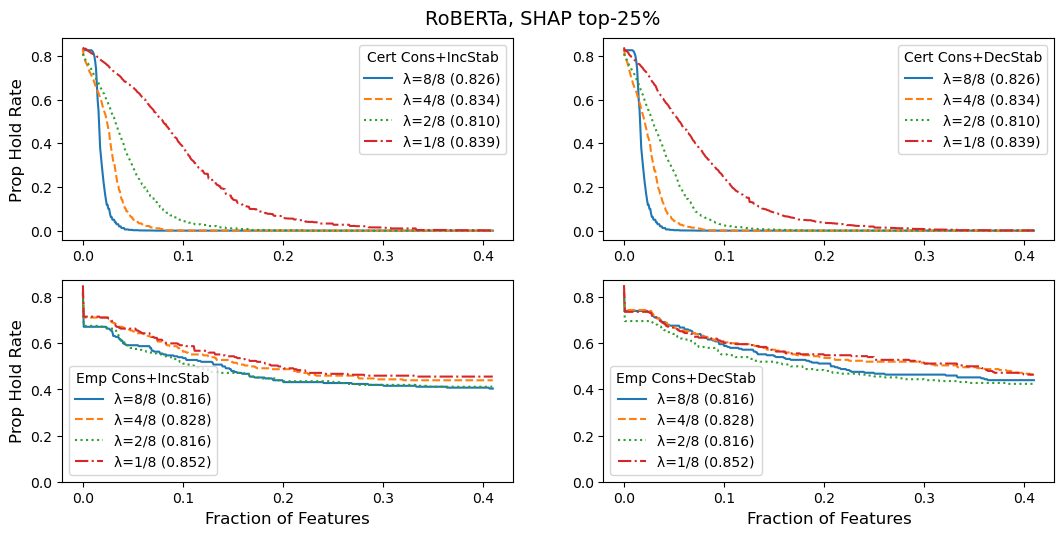

In [8]:
q1t_vit16_rs = np.linspace(0.0, 4.1, 500)
q1t_vit16_plot_rs = q1t_vit16_rs / 64
q1e_vit16_rs = np.linspace(0.0, 31.9, 500)
q1e_vit16_plot_rs = q1e_vit16_rs / 64
_ = q1_plot_cert_vs_emp("vit16", q1t_vit16_rs, q1t_vit16_plot_rs, q1e_vit16_rs, q1e_vit16_plot_rs, title="Vision Transformer, SHAP top-25%")
plt.savefig("images/q1e_vit16.png", bbox_inches="tight", transparent=True)

q1t_resnet50_rs = q1t_vit16_rs
q1t_resnet50_plot_rs = q1t_vit16_plot_rs
q1e_resnet50_rs = q1e_vit16_rs
q1e_resnet50_plot_rs = q1e_vit16_plot_rs
_ = q1_plot_cert_vs_emp("resnet50", q1t_resnet50_rs, q1t_resnet50_plot_rs, q1e_resnet50_rs, q1e_resnet50_plot_rs, title="ResNet50, SHAP top-25%")
plt.savefig("images/q1e_resnet50.png", bbox_inches="tight", transparent=True)

q1t_roberta_rs = np.linspace(0.0, 0.41, 500)
q1t_roberta_plot_rs = np.linspace(0.0, 0.41, 500)
q1e_roberta_rs = q1t_roberta_rs
q1e_roberta_plot_rs = q1t_roberta_plot_rs
_ = q1_plot_cert_vs_emp("roberta", q1t_roberta_rs, q1t_roberta_plot_rs, q1e_roberta_rs, q1e_roberta_plot_rs, title="RoBERTa, SHAP top-25%")
plt.savefig("images/q1e_roberta.png", bbox_inches="tight", transparent=True)

<Figure size 640x480 with 0 Axes>

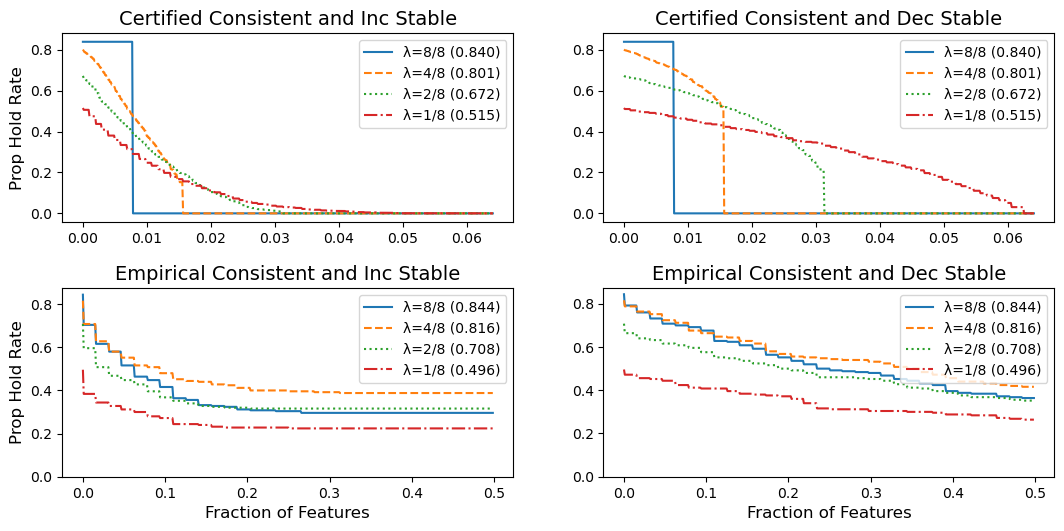

In [9]:
_ = q1_plot_cert_vs_emp("vit16", q1t_vit16_rs, q1t_vit16_plot_rs, q1e_vit16_rs, q1e_vit16_plot_rs,
                        title=None, show_lhs=True, subplot_titles=True)
plt.savefig("images/q1.png", bbox_inches="tight", transparent=True)

In [10]:
#######################################################
# Q2: Certified accuracy drop plots
#######################################################

In [11]:
q2_lambds = [16/16, 8/16, 4/16, 2/16, 1/16]

q2_vit16_dfs_q16 = [(l,load_q2("vit16", 16, l)) for l in q2_lambds]
q2_resnet50_dfs_q16 = [(l,load_q2("resnet50", 16, l)) for l in q2_lambds]
q2_roberta_dfs_q16 = [(l,load_q2("roberta", 16, l)) for l in q2_lambds]

q2_vit16_dfs_q32 = [(l,load_q2("vit16", 32, l)) for l in q2_lambds]
q2_resnet50_dfs_q32 = [(l,load_q2("resnet50", 32, l)) for l in q2_lambds]
q2_roberta_dfs_q32 = [(l,load_q2("roberta", 32, l)) for l in q2_lambds]

q2_vit16_dfs_q64 = [(l,load_q2("vit16", 64, l)) for l in q2_lambds]
q2_resnet50_dfs_q64 = [(l,load_q2("resnet50", 64, l)) for l in q2_lambds]
q2_roberta_dfs_q64 = [(l,load_q2("roberta", 64, l)) for l in q2_lambds]

q2_vit16_dfs_q128 = [(l,load_q2("vit16", 128, l)) for l in q2_lambds]
q2_resnet50_dfs_q128 = [(l,load_q2("resnet50", 128, l)) for l in q2_lambds]
q2_roberta_dfs_q128 = [(l,load_q2("roberta", 128, l)) for l in q2_lambds]

q2_rs = np.linspace(0.0, 10.01, 802)
q2_rs_roberta = np.linspace(0.0, 0.501, 502)

In [12]:
def do_q2_plot(vit16_dfs, resnet50_dfs, roberta_dfs, q=None):    
    plt.clf()
    lfs, afs, tfs = 14, 16, 18
    fig, ax = plt.subplots(1,3, figsize=(6.4 * 2.7, 4.8 * 0.8))
    
    for i, (lambd, df) in enumerate(vit16_dfs):
        drops = q2_drops(df, q2_rs)
        ax[0].plot(q2_rs/64, drops, label=f"λ={lambd_str(lambd)} ({drops[0]:.3f})", linestyle=ls[i])
    
    for i, (lambd, df) in enumerate(resnet50_dfs):
        drops = q2_drops(df, q2_rs)
        ax[1].plot(q2_rs/64, drops, label=f"λ={lambd_str(lambd)} ({drops[0]:.3f})", linestyle=ls[i])
    
    for i, (lambd, df) in enumerate(roberta_dfs):
        drops = q2_drops(df, q2_rs_roberta, div_by_p=True)
        ax[2].plot(q2_rs_roberta, drops, label=f"λ={lambd_str(lambd)} ({drops[0]:.3f})", linestyle=ls[i])
    
    ax[0].legend(loc="upper right", fontsize=lfs, title_fontsize=lfs)
    ax[1].legend(loc="upper right", fontsize=lfs, title_fontsize=lfs)
    ax[2].legend(loc="upper right", fontsize=lfs, title_fontsize=lfs)

    if q is None:
        ax[0].set_title("Vision Transformer", fontsize=tfs)
        ax[1].set_title("ResNet50", fontsize=tfs)
        ax[2].set_title("RoBERTa", fontsize=tfs)
    else:
        ax[0].set_title(f"Vision Transformer (q={q})", fontsize=tfs)
        ax[1].set_title(f"ResNet50 (q={q})", fontsize=tfs)
        ax[2].set_title(f"RoBERTa (q={q})", fontsize=tfs)
    
    ax[0].set_ylabel("Certified Accuracy", fontsize=afs)
    ax[0].tick_params(axis="y", labelsize=lfs)
    for i in [0,1,2]:
        ax[i].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])
        ax[i].set_xlabel("Fraction of Features", fontsize=afs)
        ax[i].tick_params(axis="x", labelsize=lfs)
        ax[i].tick_params(axis="y", labelsize=lfs)

    return fig

<Figure size 640x480 with 0 Axes>

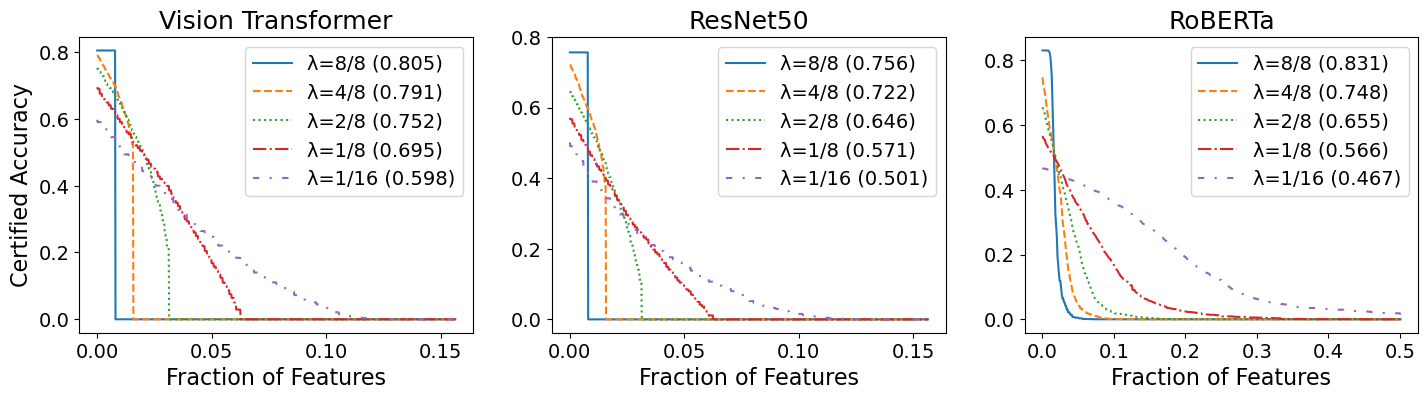

In [13]:
fig = do_q2_plot(q2_vit16_dfs_q64, q2_resnet50_dfs_q64, q2_roberta_dfs_q64)
plt.savefig("images/q2.png", bbox_inches="tight", transparent=True)

<Figure size 640x480 with 0 Axes>

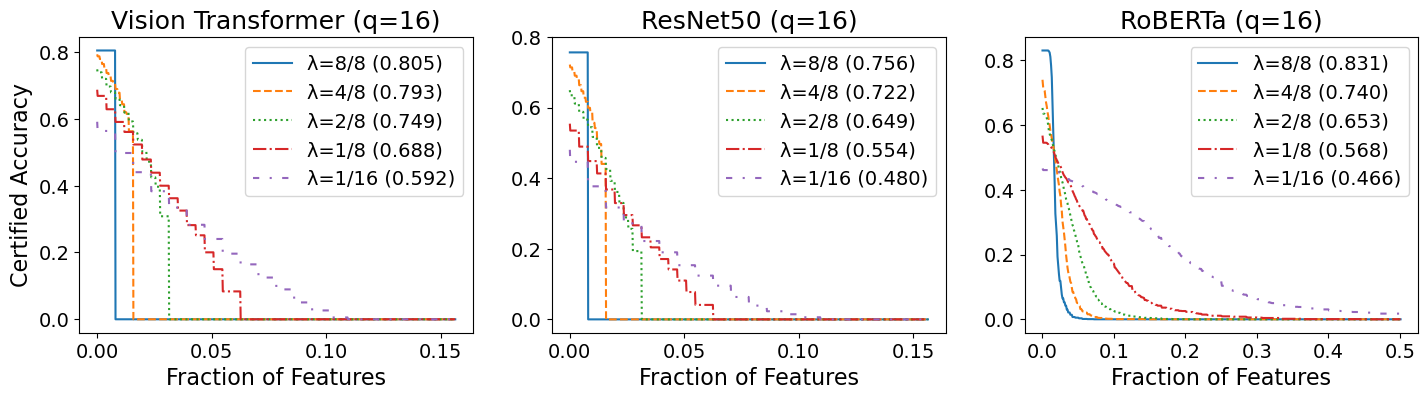

In [14]:
fig = do_q2_plot(q2_vit16_dfs_q16, q2_resnet50_dfs_q16, q2_roberta_dfs_q16, q=16)
plt.savefig("images/q2_q16.png", bbox_inches="tight", transparent=True)

<Figure size 640x480 with 0 Axes>

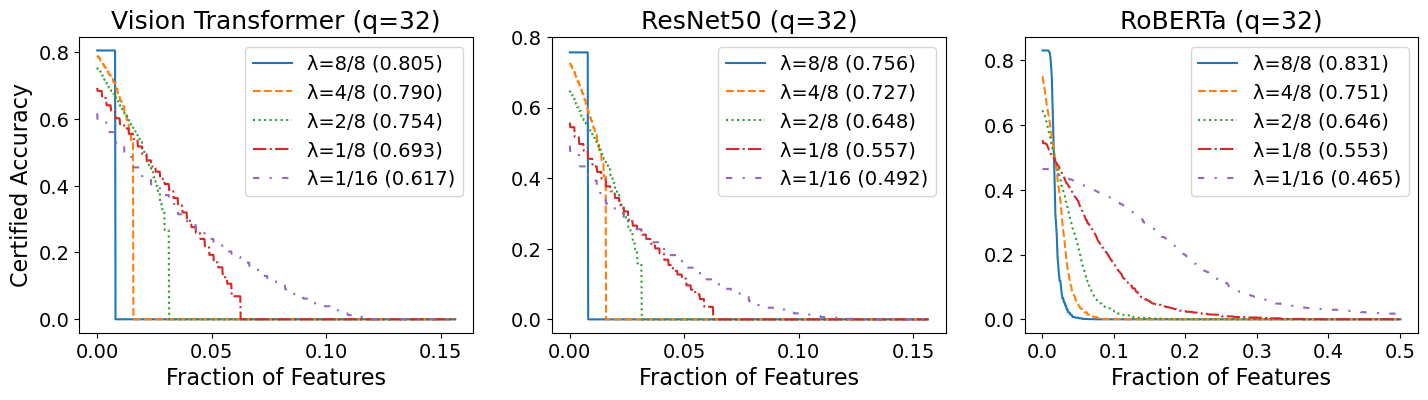

In [15]:
fig = do_q2_plot(q2_vit16_dfs_q32, q2_resnet50_dfs_q32, q2_roberta_dfs_q32, q=32)
plt.savefig("images/q2_q32.png", bbox_inches="tight", transparent=True)

<Figure size 640x480 with 0 Axes>

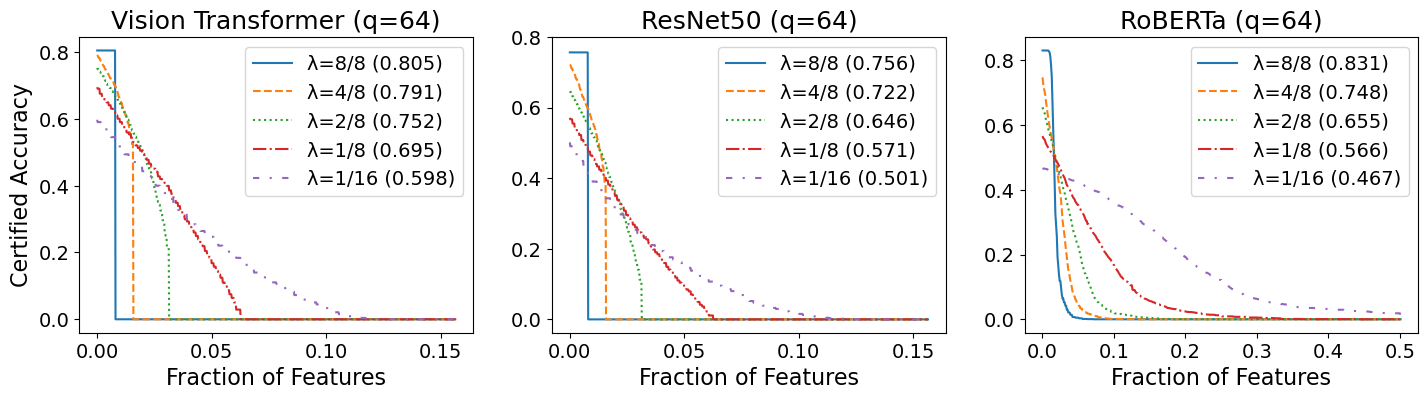

In [16]:
fig = do_q2_plot(q2_vit16_dfs_q64, q2_resnet50_dfs_q64, q2_roberta_dfs_q64, q=64)
plt.savefig("images/q2_q64.png", bbox_inches="tight", transparent=True)

<Figure size 640x480 with 0 Axes>

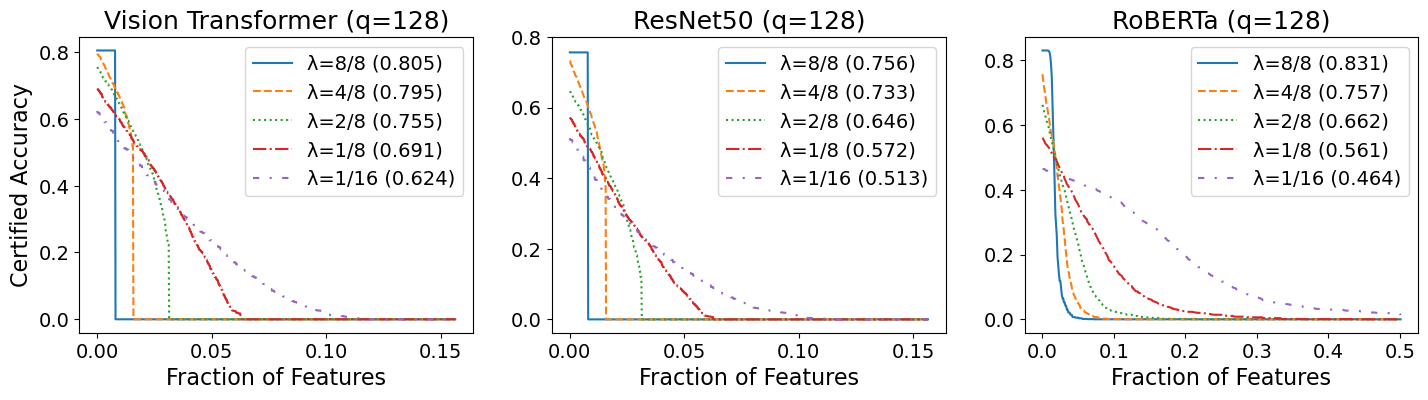

In [17]:
fig = do_q2_plot(q2_vit16_dfs_q128, q2_resnet50_dfs_q128, q2_roberta_dfs_q128, q=128)
plt.savefig("images/q2_q128.png", bbox_inches="tight", transparent=True)

In [18]:
#######################################################
# Q3 sparsity
#######################################################

In [19]:
q3_lambds = [1/8., 2/8., 3/8., 4/8.]

q3_vit16_shaps = [q3_fracs(load_q3_df("vit16", "shap", l)) for l in q3_lambds]
q3_vit16_limes = [q3_fracs(load_q3_df("vit16", "lime", l)) for l in q3_lambds]
q3_vit16_igradus = [q3_fracs(load_q3_df("vit16", "igradu", l)) for l in q3_lambds]
q3_vit16_vgradus = [q3_fracs(load_q3_df("vit16", "vgradu", l)) for l in q3_lambds]

q3_resnet50_shaps = [q3_fracs(load_q3_df("resnet50", "shap", l)) for l in q3_lambds]
q3_resnet50_limes = [q3_fracs(load_q3_df("resnet50", "lime", l)) for l in q3_lambds]
q3_resnet50_igradus = [q3_fracs(load_q3_df("resnet50", "igradu", l)) for l in q3_lambds]
q3_resnet50_vgradus = [q3_fracs(load_q3_df("resnet50", "vgradu", l)) for l in q3_lambds]

q3_roberta_shaps = [q3_fracs(load_q3_df("roberta", "shap", l)) for l in q3_lambds]
q3_roberta_limes = [q3_fracs(load_q3_df("roberta", "lime", l)) for l in q3_lambds]
q3_roberta_igradus = [q3_fracs(load_q3_df("roberta", "igradu", l)) for l in q3_lambds]
q3_roberta_vgradus = [q3_fracs(load_q3_df("roberta", "vgradu", l)) for l in q3_lambds]

q3_data = [("Vision Transformer",
                ("VGrad", q3_vit16_vgradus),
                ("IGrad", q3_vit16_igradus),
                ("LIME", q3_vit16_limes),
                ("SHAP", q3_vit16_shaps)),
           
           ("ResNet50",
                ("VGrad", q3_resnet50_vgradus),
                ("IGrad", q3_resnet50_igradus),
                ("LIME", q3_resnet50_limes),
                ("SHAP", q3_resnet50_shaps)),
          
           ("RoBERTa",
                ("VGrad", q3_roberta_vgradus),
                ("IGrad", q3_roberta_igradus),
                ("LIME", q3_roberta_limes),
                ("SHAP", q3_roberta_shaps)),
          ]

<Figure size 640x480 with 0 Axes>

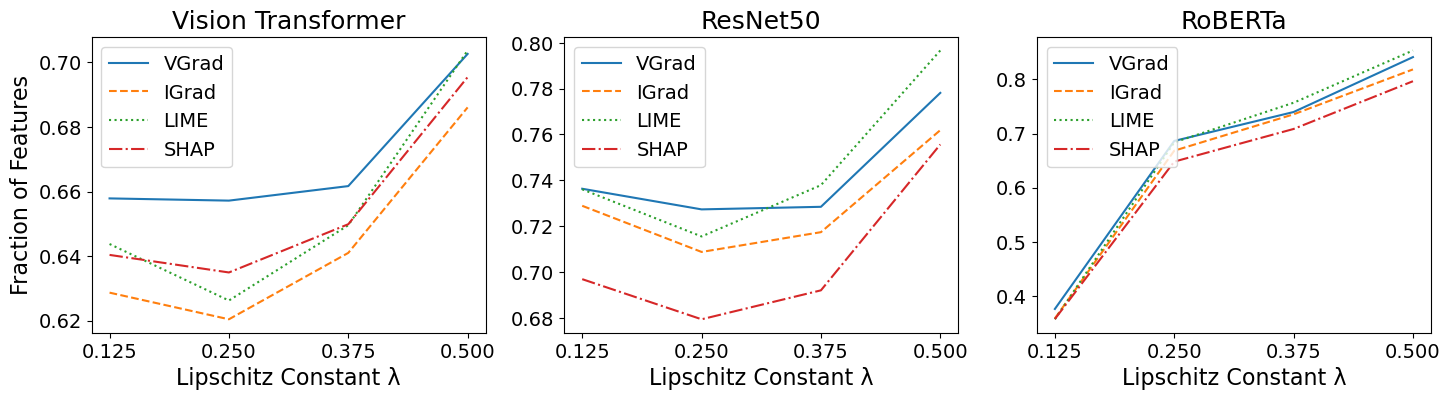

In [20]:
### Main paper plot
plt.clf()
lfs, afs, tfs = 14, 16, 18
fig, ax = plt.subplots(1,3, figsize=(6.4 * 2.7, 4.8 * 0.8))

for i, (title, f1, f2, f3, f4) in enumerate(q3_data):
    ax[i].plot(q3_lambds, f1[1], label=f1[0], linestyle=ls[0])
    ax[i].plot(q3_lambds, f2[1], label=f2[0], linestyle=ls[1])
    ax[i].plot(q3_lambds, f3[1], label=f3[0], linestyle=ls[2])
    ax[i].plot(q3_lambds, f4[1], label=f4[0], linestyle=ls[3])
    ax[i].legend(loc="upper left", fontsize=lfs, title_fontsize=lfs)
    ax[i].set_xlabel("Lipschitz Constant λ", fontsize=afs)
    ax[i].set_xticks(q3_lambds)
    ax[i].tick_params(axis="x", labelsize=lfs)
    ax[i].tick_params(axis="y", labelsize=lfs)

    
ax[0].set_title("Vision Transformer", fontsize=tfs)
ax[1].set_title("ResNet50", fontsize=tfs)
ax[2].set_title("RoBERTa", fontsize=tfs)
ax[0].set_ylabel("Fraction of Features", fontsize=afs)

plt.savefig("images/q3.png", bbox_inches="tight", transparent=True)

In [21]:
def plot_q3_method_comps(model_type, title=None, lfs=14, afs=16, tfs=18):
    plt.clf()
    fig, ax = plt.subplots(1,3, figsize=(6.4 * 2.7, 4.8 * 0.8))
    
    methods = ["VGrad", "IGrad", "LIME", "SHAP"]
    lambds = [1/8, 2/8, 3/8, 4/8]
    
    for i in range(3):
        vgrad_accs = [(q3_accs(load_q1_theory(model_type.lower(), "vgrad", (i+1)/8, l))) for l in lambds]
        igrad_accs = [(q3_accs(load_q1_theory(model_type.lower(), "igrad", (i+1)/8, l))) for l in lambds]
        lime_accs = [(q3_accs(load_q1_theory(model_type.lower(), "lime", (i+1)/8, l))) for l in lambds]
        shap_accs = [(q3_accs(load_q1_theory(model_type.lower(), "shap", (i+1)/8, l))) for l in lambds]
        
        ax[i].plot(lambds, vgrad_accs, label="VGrad", linestyle=ls[0])
        ax[i].plot(lambds, igrad_accs, label="IGrad", linestyle=ls[1])
        ax[i].plot(lambds, lime_accs, label="LIME", linestyle=ls[2])
        ax[i].plot(lambds, shap_accs, label="SHAP", linestyle=ls[3])
        
        ax[i].legend(loc="lower right", title=f"Top-{i+1}/8", fontsize=lfs, title_fontsize=lfs)
        ax[i].set_xlabel("Lipschitz Constant λ", fontsize=afs)
        ax[i].tick_params(axis="x", labelsize=lfs)
        ax[i].tick_params(axis="y", labelsize=lfs)
    
    ax[0].set_ylabel("φ(x)-Masked Accuracy", fontsize=afs)
        
    if title is not None:
        fig.suptitle(title, fontsize=tfs)
        
    return fig

''

<Figure size 640x480 with 0 Axes>

<Figure size 1728x384 with 0 Axes>

<Figure size 1728x384 with 0 Axes>

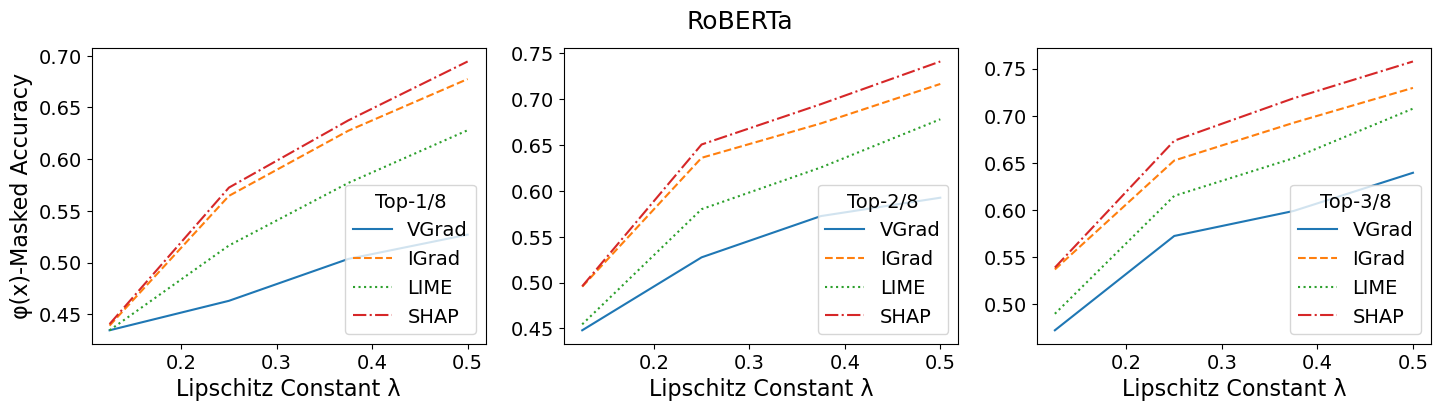

In [22]:
fig = plot_q3_method_comps("vit16", title="Vision Transformer")
plt.savefig("images/q3_methods_vit16.png", bbox_inches="tight", transparent=True)

fig = plot_q3_method_comps("resnet50", title="ResNet50")
plt.savefig("images/q3_methods_resnet50.png", bbox_inches="tight", transparent=True)

fig = plot_q3_method_comps("roberta", title="RoBERTa")
plt.savefig("images/q3_methods_roberta.png", bbox_inches="tight", transparent=True)
;

In [23]:
###########################
# Q4: Comparison with additive smoothing

In [24]:
# mus (0.716, 0.660, 0.512, 0.364), add (0.184, 0.320, 0.360, 0.156), 

q4_ticks = ["λ=8/8", "λ=4/8", "λ=2/8", "λ=1/8"]
q4_add_checkr1 = [0.184, 0.320, 0.360, 0.156]
q4_mus_checkr1 = [0.716, 0.660, 0.512, 0.364]


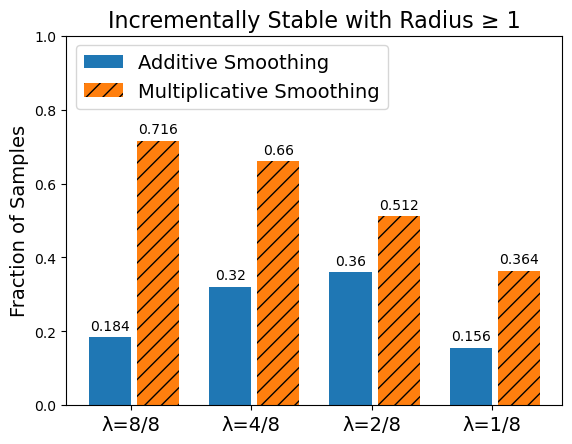

In [25]:
lfs, afs, tfs = 14, 14, 16
x = np.arange(4)
width = 0.35

fig, ax = plt.subplots()

rects = ax.bar(x, q4_add_checkr1, width=width, label="Additive Smoothing")
ax.bar_label(rects, padding=3)

rects = ax.bar(x+0.4, q4_mus_checkr1, width=width, label="Multiplicative Smoothing", hatch="//")
ax.bar_label(rects, padding=3)

ax.set_ylabel("Fraction of Samples", fontsize=afs)
ax.set_ylim(0, 1.0)
ax.legend(loc="upper left", fontsize=lfs)
ax.set_xticks(x+width/2, q4_ticks, fontsize=afs)

ax.set_title("Incrementally Stable with Radius ≥ 1", fontsize=tfs)

plt.savefig("images/q4_additive.png", bbox_inches="tight", transparent=True)

In [26]:
###########################
# Q5: Adversarial Robust Models

In [27]:
q5_ticks = ["Pretrain Only", "L2 (ε=3.0)", "L∞ (ε=4)", "L∞ (ε=8)"]
q5_adv_checkr1 = [0.208, 0.176, 0.180, 0.232]
q5_mus_checkr1 = [0.324, 0.432, 0.356, 0.448]

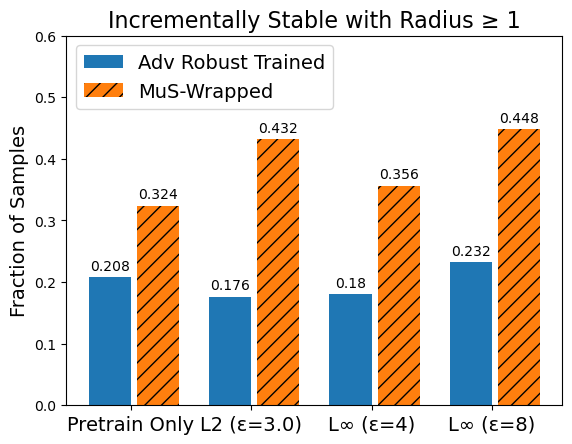

In [28]:
# lfs, afs, tfs = 12, 12, 14
# x = np.arange(4)
# width = 0.35

fig, ax = plt.subplots()

rects = ax.bar(x, q5_adv_checkr1, width=width, label="Adv Robust Trained")
ax.bar_label(rects, padding=3)

rects = ax.bar(x+0.4, q5_mus_checkr1, width=width, label="MuS-Wrapped", hatch="//")
ax.bar_label(rects, padding=3)

ax.set_ylabel("Fraction of Samples", fontsize=afs)
ax.set_ylim(0, 0.6)
ax.legend(loc="upper left", fontsize=lfs)
ax.set_xticks(x+width/2, q5_ticks, fontsize=afs)

ax.set_title("Incrementally Stable with Radius ≥ 1", fontsize=tfs)

plt.savefig("images/q5_advrobust.png", bbox_inches="tight", transparent=True)